In [2]:
import control
from control.matlab import *
import numpy as np
import sympy as sp
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 1
%matplotlib inline

def mystepinfo(sys, t=None, SettlingTimeThreshold=0.02, RiseTimeLimits=[0.1,0.9]):
#     sys = control.timeresp._get_ss_simo(sys)
    
    t, step_out = control.step_response(sys, t)
    step_out = step_out.flatten()
        
    # Steady state value
    InfValue = step_out[-1]
    
    # RiseTime
    tr_lower_index = (np.where(step_out >= RiseTimeLimits[0] * InfValue)[0])[0]
    tr_upper_index = (np.where(step_out >= RiseTimeLimits[1] * InfValue)[0])[0]
    RiseTime = t[tr_upper_index] - t[tr_lower_index]

    # SettlingTime
    sup_margin = (1. + SettlingTimeThreshold) * InfValue
    inf_margin = (1. - SettlingTimeThreshold) * InfValue
    SettlingTime = 0
    for i in reversed(range(t.size)):
        if (step_out[i] <= inf_margin) | (step_out[i] >= sup_margin):
            if t.size > i + 1:
                i += 1
            SettlingTime = t[i]
            break
    
    # Peak
    PeakIndex = np.abs(step_out).argmax()
    PeakValue = step_out[PeakIndex]
    PeakTime = t[PeakIndex]
    SettlingMax = (step_out).max()
    SettlingMin = (step_out[tr_upper_index:]).min()
    UnderShoot = step_out.min()
    OverShoot = 100. * (step_out.max() -InfValue) / (InfValue -step_out[0])
    
    S = {
        'RiseTime': RiseTime,
        'SettlingTime': SettlingTime,
        'SettlingMin': SettlingMin,
        'SettlingMax': SettlingMax,
        'Overshoot': OverShoot,
        'Undershoot': UnderShoot,
        'Peak': PeakValue,
        'PeakTime': PeakTime,
        'SteadyStateValue': InfValue
    }

    return S

def FOM(S, SettlingTimeThreshold):
    # calcula o zeta necessário usando Mp
    zeta = -np.log(S['Overshoot'] / 100.) / np.sqrt( np.pi**2 + np.log(S['Overshoot'] / 100.)**2 )
    
    # calcula o wn necessário usando zeta
    try:
        wn = np.pi / (S['PeakTime'] * np.sqrt(1 - zeta**2) )
    except:
        wn = - np.log(SettlingTimeThreshold * np.sqrt(1 - zeta**2)) / (S['SettlingTime'] * zeta)
    Fn = wn * 2 * np.pi
    wd = wn * np.sqrt(1 - zeta**2)
    Fd = wd * 2 * np.pi
    
    FOM = {
        'zeta': zeta,
        'wn': wn,
        'Fn': Fn,
        'wd': wd,
        'Fd': Fd
    }
    return FOM

def zplane(sys, color='black'):
    t = np.arange(-np.pi, np.pi, 0.01)
    ax = np.arange(-1.1, 1.1, 0.01)
    plt.plot(np.cos(t), np.sin(t), lw=1)
    plt.plot(ax, ax * 0, color='black', lw=1)
    plt.plot(ax * 0, ax, color='black', lw=1)

    for p in pole(sys):
        plt.scatter(p.real, p.imag, marker='x', color=color, lw=1)
    for z in zero(sys):
        plt.scatter(z.real, z.imag, marker='o', facecolors='none', color=color, lw=1)


# 1. SISTEMA EM MALHA FECHADA

## 1.1 RESPOSTA AO DEGARU
![Resposta ao Degrau](SCT2_bloco2/completo/ALL0000/F0000TEK.JPG)

## 1.2 TEMPO DE SUBIDA
![Tempo de Subida](SCT2_bloco2/completo/ALL0001/F0001TEK.JPG)

In [3]:
v0 = 1.00
print(f'v0 = {v0} v')
vinf = 1.51
print(f'vinf = {vinf} v')

deltav = vinf - v0
print(f'deltav = {deltav} v')

v10 = deltav * 0.1 + v0
v90 = deltav * 0.9 + v0
print(f'v10 = {v10} v')
print(f'v90 = {v90} v')

t10 = 3.5e-3
t90 = 13.2e-3
print(f't10 = {t10} s')
print(f't90 = {t90} s')
RiseTime = t90 - t10
print(f'RiseTime = {RiseTime} s')

v0 = 1.0 v
vinf = 1.51 v
deltav = 0.51 v
v10 = 1.051 v
v90 = 1.459 v
t10 = 0.0035 s
t90 = 0.0132 s
RiseTime = 0.0097 s


## 1.3 TEMPO DE ATRASO
![Tempo de Atraso](SCT2_bloco2/completo/ALL0002/F0002TEK.JPG)

In [4]:
deltav = vinf - v0
print(f'deltav = {deltav} v')

v50 = deltav * 0.5 + v0
print(f'v50 = {v50} v')
t50 = 8.2e-3
print(f'Delay = {t50} s')

deltav = 0.51 v
v50 = 1.255 v
Delay = 0.0082 s


## 1.4 PICO E TEMPO DE PICO
![Pico e Tempo de Pico](SCT2_bloco2/completo/ALL0003/F0003TEK.JPG)

In [5]:
PeakTime = 21.2e-3
print(f'PeakTime = {PeakTime} s')

PeakValue = 1.54
print(f'PeakValue = {PeakValue} v')

OverShoot = 100 * (PeakValue - vinf) / (vinf - v0)
print(f'OverShoot = {OverShoot} %')

PeakTime = 0.0212 s
PeakValue = 1.54 v
OverShoot = 5.8823529411764754 %


## 1.5 TEMPO DE ACOMODAÇÃO
![Tempo de Acomodação](SCT2_bloco2/completo/ALL0005/F0005TEK.JPG)

In [6]:
SettlingTimeThreshold = 0.05
sup_margin = (1. + SettlingTimeThreshold) * deltav +v0
inf_margin = (1. - SettlingTimeThreshold) * deltav +v0
print(f'sup_margin = {sup_margin} v')
print(f'inf_margin = {inf_margin} v')
SettlingTime = 25.6e-3
print(f'SettlingTime = {SettlingTime} s')

sup_margin = 1.5355 v
inf_margin = 1.4845 v
SettlingTime = 0.0256 s


## 1.6 FUNÇÃO DE TRANSFERÊNCIA EQUIVALENTE

In [7]:
zeta = -np.log(OverShoot / 100.) / np.sqrt(  (-np.pi)**2 + (np.log(OverShoot / 100.))**2  )
wn = np.pi / (PeakTime * np.sqrt(1 - zeta**2) )
print(f'zeta = {zeta}')
print(f'wn = {wn}')
zeta_check = np.sqrt(1 - ((np.pi)/(wn * PeakTime))**2)
print(f'zeta_check = {zeta_check}')

zeta = 0.6697192345378495
wn = 199.5495007139792
zeta_check = 0.6697192345378495



        3.982e+04
-------------------------
s^2 + 267.3 s + 3.982e+04

T.size: 100
T.shape: (100,)
yout.size: 100
yout.shape: (100,)
{
    "RiseTime": 0.010581553289198097,
    "SettlingTime": 0.024866650229615525,
    "SettlingMin": 0.9223452999306766,
    "SettlingMax": 1.058821930048983,
    "Overshoot": 5.977862151701064,
    "Undershoot": 0.0,
    "Peak": 1.058821930048983,
    "PeakTime": 0.021163106578396193,
    "SteadyStateValue": 0.9990972723466923
}
{
    "zeta": 0.6676116061208783,
    "wn": 199.38848505176554,
    "Fn": 1252.79479969805,
    "wd": 148.44666788177528,
    "Fd": 932.7179225345383
}


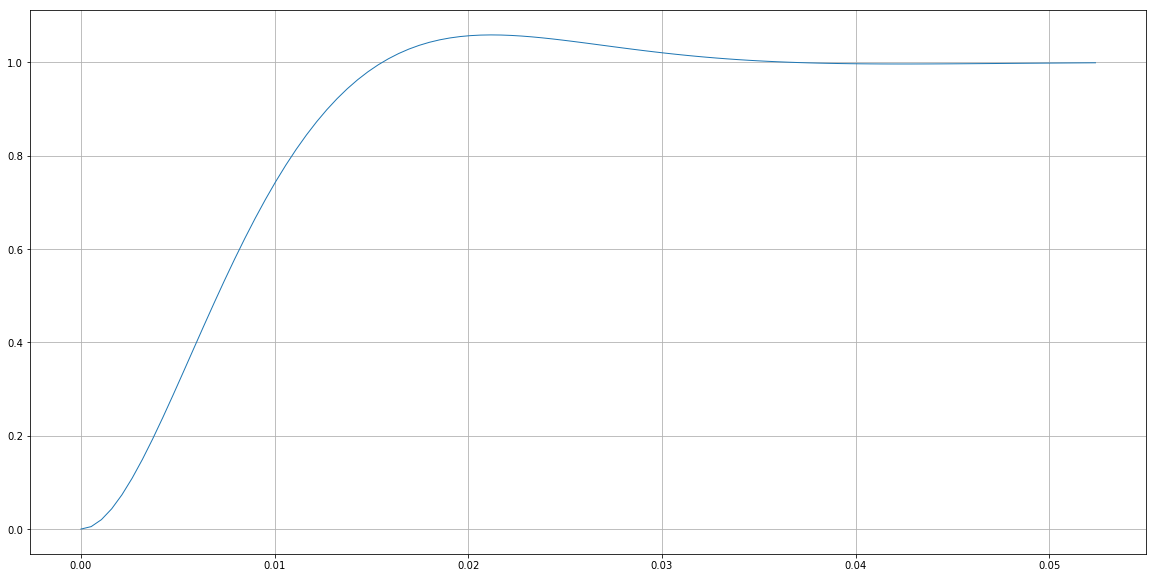

In [9]:
G2_s = tf([wn**2],[1, 2 * zeta * wn, wn**2])
print(G2_s)
plt.figure(figsize=(20,10))
step_out, t = step(G2_s)
plt.plot(t, step_out)
plt.grid()

S = stepinfo(G2_s, t, SettlingTimeThreshold=SettlingTimeThreshold)
fom = FOM(S, SettlingTimeThreshold)

print(json.dumps(S, indent=4))
print(json.dumps(fom, indent=4))

In [15]:
# Representação polar
Ts = 1/1000
p1_r = np.exp(-Ts * fom['zeta'] * fom['wn'])
p1_theta = np.degrees(Ts * fom['wd'])
print(f'Pólo P1 -> [{p1_r}, {p1_theta}°]')

# Representação retangular
p1 = p1_r * np.exp(1j * Ts * fom['wd'])
print(f'Pólo P1 -> {p1}')

polo_dominante_desejado = tf(1, np.poly([p1, p1.conjugate()]), Ts)
print(polo_dominante_desejado)
# plt.figure(figsize=(20,10))
# zplane(polo_dominante_desejado, color='blue')
# zplane(G_z)

Pólo P1 -> [0.8753652363484555, 8.505367552405957°]
Pólo P1 -> (0.8657379800012116+0.1294683242758982j)

          1
----------------------
z^2 - 1.731 z + 0.7663

dt = 0.001

